In [1]:
import sys
sys.path.insert(0,'C:/Users/owner/Documents/GitHub/gym-warehouse')

import gym
import gym_warehouse
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd

from mpl_toolkits.axes_grid1 import AxesGrid

env = gym.make('warehouse-v0')
# env.render()

pygame 1.9.5
Hello from the pygame community. https://www.pygame.org/contribute.html
SHAPE OF CLASS MAP:  (5, 10)


In [2]:
class Robot:

    def __init__(self,location,name):
        self.entrance = location
        self.location = location
        self.name = name
        self.loaded = False
        self.assignment = None
        self.sorted_orders = None
        self.fulfilled = 0
#         self.next_move = (0,0)
        
    def get_closest_orders(self,orders):

        ord_dist=[]
        for i in orders:

            distance = abs(self.location[0] - i.location[0]) + abs(self.location[1] - i.location[1])
            moves = (self.location[0]-i.location[1],self.location[1]-i.location[1])
        
            ord_dist.append([i, distance])
            
        self.sorted_orders = sorted(ord_dist, key=lambda x: x[1])
        
    
    def is_loaded(self,warehouse):
        if self.assignment is not None:
            if self.location == self.assignment.location:
                self.loaded=True
                warehouse.clear_order(self.assignment)
                self.clear_order()
        else:
#             LOOP THROUGH ALL ORDERS TO SEE IF WE ARE ON AN ORDER
            for i in warehouse.orders:
                if i.location == self.location:
                    self.loaded=True
                    warehouse.clear_order(i)
            
            
    def step(self,dir_,warehouse):
        

        
        old_loc = self.location
        self.location = [sum(x) for x in zip(self.location, dir_)]
        
        if self.assignment == None and self.loaded==True:
            if self.location == self.entrance:
                self.loaded = False
                self.fulfilled +=1
            else:
                pass
        elif self.loaded == False:
            self.is_loaded(warehouse)
        
       # print("Robot:  ", self, " old_loc: ", old_loc)
        
              
    def assign(self,order,override=False):
        
        if order == None and override:
            if self.assignment is not None:
                self.assignment.assignment = None
            self.assignment = order
            return True   
        
        elif order.assignment == None:
            
            if self.assignment is not None:
                self.assignment.assignment = None
                
            self.assignment = order
            order.assign(self)    
            return True
        
        elif override:
            if self.assignment is not None:
                self.assignment.assignment = None
                self.assignment = None
            self.assignment = order
            order.assignment.assignment = None
            order.assign(self)
            return True           
        
        elif self.assignment==order:
            return True
        
        return False
        
    
    def get_dist(self,order):
        if order is None:
            return 0
        return abs(self.location[0] - order.location[0]) + abs(self.location[1] - order.location[1])
    
    def get_direction(self,location):
        
        return ((self.location[0] - location[0]) , (self.location[1] - location[1]))
    
    def find_next_move(self):
        
        self.is_loaded(warehouse)
        
        if self.loaded:
            (up,right) = self.get_direction(self.entrance)
        elif self.assignment == None:
            return [0,0]
        else:
            (up,right) = self.get_direction(self.assignment.location)
        
        if up==0:
            temp_up=0
        elif up > 0:
            temp_up = min(max(up,0),-1)
        else:
            temp_up = max(min(up,0),1)
        
        
        if right==0:
            temp_right=0
        elif right > 0:
            temp_right = min(max(right,0),-1)
        else:
            temp_right = max(min(right,0),1)
        
        #print("Robot: ", self ," Get Directions: ",(up,right), " temp_up: ",temp_up," temp_right: ", temp_right)
        
        return [temp_up,temp_right]
    

    
    def __str__(self):
        return f'{self.name} at {self.location}'
        
    def __repr__(self):
        return f'{self.name} at {self.location}'              
        
    def clear_order(self):       
        self.assignment = None

In [3]:
class Order:
    
    def __init__(self,location):
        self.location = location
        self.assignment = None
        
    def assign(self,robot):
        self.assignment = robot
        
    def __str__(self):
        return f'Location of Order is {self.location} and assignment is {self.assignment}'
        
    def __repr__(self):
        return f'Location of Order is {self.location} and assignment is {self.assignment}'


In [4]:
class Warehouse:
    
    def __init__(self,locations):
        self.robot_1_location = locations[0]
        self.robot_2_location = locations[1]
        
        self.robot_1 = Robot(self.robot_1_location,"Robot-1")
        self.robot_2 = Robot(self.robot_2_location,"Robot-2")
        
        self.orders = []
        
    def new_order(self,location):
        order = Order(location)
        self.orders.append(order)
        
    def order_by_closeness(self):
        self.robot_1.get_closest_orders(self.orders)
        self.robot_2.get_closest_orders(self.orders)
        
    def print_orders(self):
        print(self.orders)
        
    def get_cost(self):
        return self.robot_1.get_dist(self.robot_1.assignment) + self.robot_2.get_dist(self.robot_2.assignment)
    
    def check_swap(self):
        
        current_cost = self.get_cost()
        swap_cost = self.robot_1.get_dist(self.robot_2.assignment) + self.robot_2.get_dist(self.robot_1.assignment)
        
        
        if swap_cost < current_cost:
            self.robot_1.assign(self.robot_2.assignment,True)
            self.robot_2.assign(self.robot_1.assignment,True)
#             print("swap occured")
            
#         else:
#             print("NO swap")
            
    def interpret_move(self,dir_,vert):
        if vert == True:
            if dir_==1:
                return 1
            elif dir_== -1:
                return 2
            
        elif vert==False:
            if dir_== 1:
                return 4
            elif dir_==-1:
                return 3
            

    def move_robot(self,robot_a,robot_b,warehouse):
        
        temp = robot_a.find_next_move()
            
        up_move = [temp[0],0]
        right_move = [0,temp[1]]
        
        if [sum(x) for x in zip(robot_a.location, up_move)] == robot_b.location:
            temp[0] = 0 #can't go up
            if temp[1] == 0:
                
                if robot_a.location[1]==0:
                    temp[1] = 1
                elif robot_a.location[1]==4:
                    temp[1] = -1
                else:
                    if np.random.uniform() < 0.5:
                        temp[1] = 1
                    else:
                        temp[1] = -1
                    
        elif [sum(x) for x in zip(robot_a.location, right_move)] == robot_b.location:
            temp[1] = 0 #can't go right  
            if temp[0] == 0:
                
                if robot_a.location[0]==0:
                    temp[0] = 1
                elif robot_a.location[0]==9:
                    temp[0] = -1
                else:
                    if np.random.uniform() < 0.5:
                        temp[0] = 1
                    else:
                        temp[0] = -1
        

        if temp[0]==0:
            robot_a.step([0,temp[1]],warehouse)
            return self.interpret_move(temp[1],vert=False)
        
        elif temp[1]==0:
            robot_a.step([temp[0],0],warehouse)
            return self.interpret_move(temp[0],vert=True)

        else:
            if np.random.uniform() < 0.5:
                robot_a.step([temp[0],0],warehouse)
                return self.interpret_move(temp[0],vert=True)
            else:
                robot_a.step([0,temp[1]],warehouse)
                return self.interpret_move(temp[1],vert=False)

    
    
    def get_order_locations(self):
        return [order.location for order in self.orders]
    
    def clear_order(self,order):
        for i in self.orders:
            if i.location==order.location:
                self.orders.remove(i)
        
    


In [5]:
warehouse = Warehouse([[0,1],[0,3]])

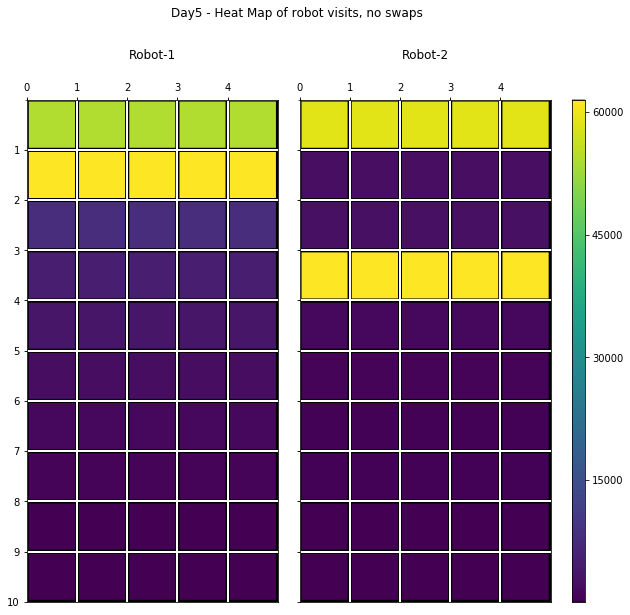

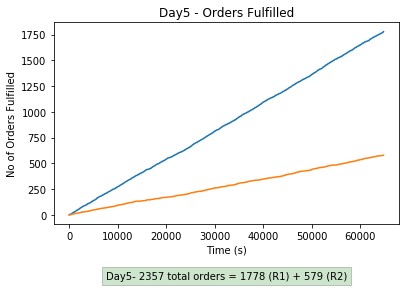

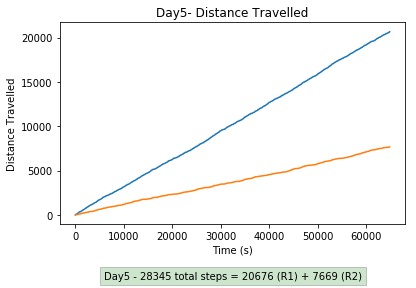

In [6]:
Days = [5]

for day in Days:
    rew1=[]
    rew2=[]
    cum_rew = [0,0]

    distance1 = []
    distance2 = []

    fulfilled1 = []
    fulfilled2 = []

    heat1 = np.zeros((10,5))
    heat2 = np.zeros((10,5))

    no_steps = 64800 #no of secs in an 18 hr day

    # no_steps=int(no_steps/2)

    %timeit
    for s in range(no_steps):

        obs,rew,done,info = env.step([0,0])
        obs=obs.T

        # Every time I take a step, do the following to retrieve new orders
        order_locations = warehouse.get_order_locations()
        for i in range(obs.shape[0]):
            for j in range(obs.shape[1]):
                if [i,j] not in order_locations:
                    if obs[i][j] == 1 or obs[i][j] == -2:
                        warehouse.new_order([i,j])

        warehouse.order_by_closeness()
        #env.render()
        #warehouse.print_orders()

        if len(warehouse.orders)>0:
            idx_1 = 0
            idx_2 = 0
            # assign robot 1 to closest order
            if warehouse.robot_1.loaded == False:
                assignment_1 = warehouse.robot_1.assign(warehouse.robot_1.sorted_orders[idx_1][0])
                idx_1+=1
                while assignment_1 == False and idx_1<len(warehouse.orders): 
                    assignment_1 = warehouse.robot_1.assign(warehouse.robot_1.sorted_orders[idx_1][0])  
                    idx_1+=1

            # assign robot 2 to closest order
            if warehouse.robot_2.loaded == False:
                assignment_2 = warehouse.robot_2.assign(warehouse.robot_2.sorted_orders[idx_2][0])
                idx_2+=1
                while assignment_2 == False and idx_2<len(warehouse.orders):
                    assignment_2 = warehouse.robot_2.assign(warehouse.robot_2.sorted_orders[idx_2][0])  
                    idx_2+=1

    #         swap
#             if len(warehouse.orders)>0:
#                 warehouse.check_swap()

        r1_move = 0
        r2_move = 0

        #move the robot
        if warehouse.robot_1.loaded == True or warehouse.robot_1.assignment is not None:
            r1_move = warehouse.move_robot(warehouse.robot_1,warehouse.robot_2,warehouse)
        if warehouse.robot_2.loaded == True or warehouse.robot_2.assignment is not None:
            r2_move = warehouse.move_robot(warehouse.robot_2,warehouse.robot_1,warehouse)


        rew=[0,0]    
        obs,rew,done,info = env.step([r1_move,r2_move])

        distance1.append(info[0])
        distance2.append(info[1])

        fulfilled1.append(warehouse.robot_1.fulfilled)
        fulfilled2.append(warehouse.robot_2.fulfilled)

        heat1[warehouse.robot_1.location] +=1
        heat2[warehouse.robot_2.location] +=1

        cum_rew[0] = cum_rew[0] + rew[0]
        cum_rew[1] = cum_rew[1] + rew[1]
        rew1.append(rew[0])
        rew2.append(rew[1])

    total_orders = len(warehouse.orders) + warehouse.robot_1.fulfilled + warehouse.robot_2.fulfilled

    fig = plt.figure(figsize=(10, 10))

    grid = AxesGrid(fig, 111,
                    nrows_ncols=(1, 2),
                    axes_pad=0.3,
                    cbar_mode='single',
                    cbar_location='right',
                    cbar_pad=0.3
                    )

    heat_maps = [np.flip(heat1,0), np.flip(heat2,0)]
    robots = ['Robot-1', 'Robot-2']

    for h, ax, r in zip(heat_maps,grid, robots):

        im = ax.pcolor(h, edgecolors='k', linewidths=4) #ax.imshow(h)

        ax.set_xticks(np.arange(0,5,1))
        ax.set_yticks(np.arange(0,10,1))

        # Labels for major ticks
        ax.set_xticklabels(np.arange(0, 5, 1));
        ax.set_yticklabels(np.arange(10, 0, -1));

        # Minor ticks
        ax.set_xticks(np.arange(0, 5, 1), minor=True);
        ax.set_yticks(np.arange(10, 0, -1), minor=True);

        # Gridlines based on minor ticks
        ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

        ax.xaxis.tick_top()
        ax.set_title(r, y=1.07)

    # when cbar_mode is 'single', for ax in grid, ax.cax = grid.cbar_axes[0]

    cbar = ax.cax.colorbar(im)
    cbar = grid.cbar_axes[1].colorbar(im)

    plt.suptitle("Day" + str(day) + " - Heat Map of robot visits, no swaps")
    plt.savefig("Day" + str(day) + "Heat_noswaps.png")
    plt.show()


    caption = "Day" + str(day) + "- {} total orders = {} (R1) + {} (R2)".format(total_orders,warehouse.robot_1.fulfilled,warehouse.robot_2.fulfilled)

    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))

    ax1.set_title("Day" + str(day) + " - Orders Fulfilled")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("No of Orders Fulfilled")

    # make the edge colors match the facecolors
    ax1.plot(fulfilled1,label="robot-1")
    ax1.plot(fulfilled2,label="robot-2")

    # center text
    fig.text(.5, 0.01, caption, ha='center', bbox=dict(facecolor='g', alpha=0.2))
    plt.savefig("Day" + str(day) +"fulfilled_noswaps.png")
    plt.show()


    caption = "Day" + str(day) + " - {} total steps = {} (R1) + {} (R2)".format(distance1[-1]+distance2[-1],distance1[-1],distance2[-1])

    fig = plt.figure()
    ax1 = fig.add_axes((0.1, 0.2, 0.8, 0.7))

    ax1.set_title("Day" + str(day) + "- Distance Travelled")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Distance Travelled")

    # make the edge colors match the facecolors
    ax1.plot((distance1),label="robot-1")
    ax1.plot((distance2),label="robot-2")

    # center text
    fig.text(.5, 0.01, caption, ha='center', bbox=dict(facecolor='g', alpha=0.2))
    plt.savefig("Day" + str(day) +"_distance_noswaps.png")
    plt.show()
